# Malicious URL Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
from tqdm import tqdm

In [3]:
from re import compile
from urllib.parse import urlparse
from socket import gethostbyname

In [4]:
df = pd.read_csv('../Datasets/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df.shape

(651191, 2)

In [6]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

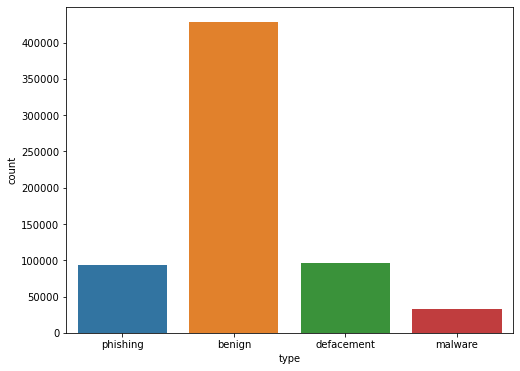

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='type');

## Feature Extraction

In [8]:
import whois
from datetime import datetime, timezone
import math
from pyquery import PyQuery
from requests import get
from interruptingcow import timeout

In [5]:
example_url = 'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15'

In [6]:
domain = example_url.split('//')[-1].split('/')[0]
domain

'www.garage-pirenne.be'

Testing Whois Library

In [7]:
whois.whois("google.com")

Error trying to connect to socket: closing socket - timed out


{'domain_name': None,
 'registrar': None,
 'whois_server': None,
 'referral_url': None,
 'updated_date': None,
 'creation_date': None,
 'expiration_date': None,
 'name_servers': None,
 'status': None,
 'emails': None,
 'dnssec': None,
 'name': None,
 'org': None,
 'address': None,
 'city': None,
 'state': None,
 'registrant_postal_code': None,
 'country': None}

In [12]:
response = get("https://google.com")
pq = PyQuery(response.text)

In [9]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [10]:
UrlFeaturizer('https://google.com').run()

{'entropy': -3.57243125132212,
 'numDigits': 0,
 'urlLength': 18,
 'numParams': 0,
 'hasHttp': False,
 'hasHttps': True,
 'urlIsLive': False,
 'bodyLength': 10643,
 'numTitles': 0,
 'numImages': 1,
 'numLinks': 27,
 'scriptLength': 8532,
 'specialChars': 3081,
 'ext': 'com',
 'dsr': 0,
 'dse': 0,
 'sscr': 2.769230769230769,
 'sbr': 0.8016536690782674,
 'bscr': 0.2894860471671521,
 'num_%20': 0,
 'num_@': 0,
 'has_ip': 0}

In [12]:
url = "https://google.com"

In [13]:
urlparse = urlparse(url)

In [14]:
def url_host_is_ip():
    host = urlparse.netloc
    pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
    match = pattern.match(host)
    return match is not None

In [15]:
url_host_is_ip()

False

In [22]:
def get_ip():
    ip = urlparse.netloc if url_host_is_ip() else gethostbyname(urlparse.netloc)
    print(ip)

In [23]:
get_ip()

142.250.195.238


In [24]:
def url_path_length():
        print(len(urlparse.path))
url_path_length()

0


In [25]:
def url_host_length():
    print(len(urlparse.netloc))
url_host_length()

10


In [26]:
def url_has_port_in_string():
        has_port = urlparse.netloc.split(':')
        print(len(has_port) > 1 and has_port[-1].isdigit())
url_has_port_in_string()

False


In [27]:
def is_encoded():
    print('%' in url.lower())
is_encoded()

False


In [28]:
def num_encoded_char():
        encs = [i for i in url if i == '%']
        print(len(encs))
num_encoded_char()

0


In [29]:
def number_of_subdirectories():
        d = urlparse.path.split('/')
        print(len(d))
number_of_subdirectories()

1


In [30]:
def number_of_periods():
        periods = [i for i in url if i == '.']
        print(len(periods))
number_of_periods()

1


In [32]:
def has_client_in_string():
    print('client' in url.lower())

def has_admin_in_string():
    print('admin' in url.lower())

def has_server_in_string():
    print('server' in url.lower())

def has_login_in_string():
    print('login' in url.lower())

def get_tld():
    print(urlparse.netloc.split('.')[-1].split(':')[0])
has_client_in_string()
has_admin_in_string()
has_server_in_string()
has_login_in_string()
get_tld()

False
False
False
False
com


In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading the data

In [4]:
df1 = pd.read_csv('../Datasets/feature_extraction1.csv')
df2 = pd.read_csv('../Datasets/feature_extraction2.csv')
df3 = pd.read_csv('../Datasets/feature_extraction3.csv')

C:\Users\nihal\AppData\Local\Temp\ipykernel_34552\2911954700.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../Datasets/feature_extraction2.csv')


In [5]:
df1.shape, df2.shape, df3.shape

((350000, 32), (301191, 32), (1190, 32))

In [6]:
df = pd.concat([df1, df2, df3])
df.shape

(652381, 32)

In [7]:
df.head()

,url,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,ext,num_%20,num_@,...,tld,count_arate,count_asterisk,count_questionmark,count_plus,count_exclamation,count_hyphen,count_equal,count_tilted,target
0,br-icloud.com.br,-3.375000,0,16,0,False,False,br,0,0,...,NaN,0,0,0,0,0,1,0,0,phishing
1,mp3raid.com/music/krizz_kaliko.html,-4.079143,1,35,0,False,False,html,0,0,...,NaN,0,0,0,0,0,0,0,0,benign
2,bopsecrets.org/rexroth/cr/1.htm,-3.708093,1,31,0,False,False,htm,0,0,...,NaN,0,0,0,0,0,0,0,0,benign
3,http://www.garage-pirenne.be/index.php?option=...,-4.660343,7,88,3,True,False,php?option=com_content&view=article&id=70&vsig...,0,0,...,be,0,0,1,0,0,1,4,0,defacement
4,http://adventure-nicaragua.net/index.php?optio...,-4.980518,22,235,2,True,False,php?option=com_mailto&tmpl=component&link=aHR0...,0,0,...,net,0,0,1,0,0,1,3,0,defacement


In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df['target'].value_counts()

benign        428080
defacement     95308
phishing       94092
malware        23645
Name: target, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641125 entries, 0 to 301190
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   url                       641125 non-null  object 
 1   entropy                   641125 non-null  float64
 2   numDigits                 641125 non-null  int64  
 3   urlLength                 641125 non-null  int64  
 4   numParams                 641125 non-null  int64  
 5   hasHttp                   641125 non-null  bool   
 6   hasHttps                  641125 non-null  bool   
 7   ext                       640964 non-null  object 
 8   num_%20                   641125 non-null  int64  
 9   num_@                     641125 non-null  int64  
 10  has_ip                    641125 non-null  int64  
 11  path_length               641125 non-null  int64  
 12  host_length               641125 non-null  int64  
 13  has_port                  641125 non-null  b

In [11]:
df.isna().sum()

url                              0
entropy                          0
numDigits                        0
urlLength                        0
numParams                        0
hasHttp                          0
hasHttps                         0
ext                            161
num_%20                          0
num_@                            0
has_ip                           0
path_length                      0
host_length                      0
has_port                         0
is_encoded                       0
num_encoded_char                 0
number_of_subdirectories         0
number_of_periods                0
has_client_in_string             0
has_admin_in_string              0
has_server_in_string             0
has_login_in_string              0
tld                         463171
count_arate                      0
count_asterisk                   0
count_questionmark               0
count_plus                       0
count_exclamation                0
count_hyphen        

In [12]:
df.drop('tld', axis=1, inplace=True)

In [13]:
df['has_ip'].value_counts()

0    641125
Name: has_ip, dtype: int64

In [14]:
df.drop('has_ip', axis=1, inplace=True)

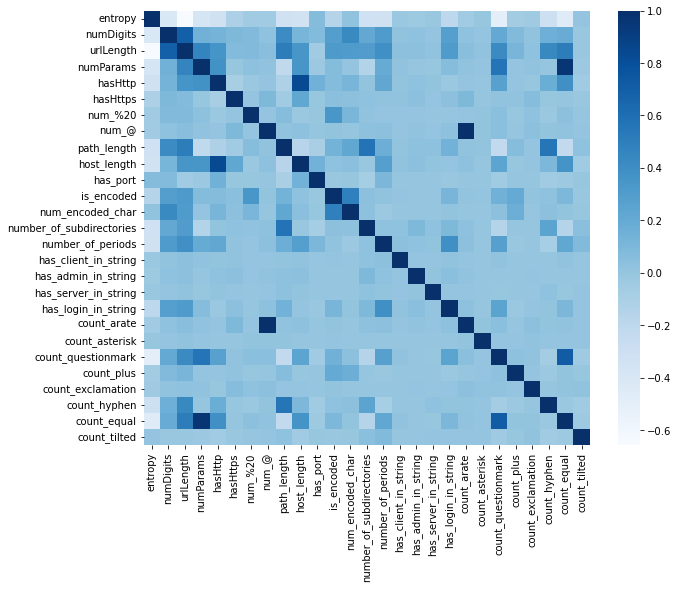

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.dropna().corr(), cmap='Blues');

In [16]:
df['ext']

0                                                        br
1                                                      html
2                                                       htm
3         php?option=com_content&view=article&id=70&vsig...
4         php?option=com_mailto&tmpl=component&link=aHR0...
                                ...                        
301186                                                  com
301187                                                  net
301188                                                  htm
301189                                                  com
301190                                                 html
Name: ext, Length: 641125, dtype: object

In [17]:
def clean_ext(ext):
    if(isinstance(ext, str)):
        if '?' in ext:
            return ext.split('?')[0]
        return ext
    else:
        return ""

In [18]:
clean_ext('exe?id=950942&hash=5')

'exe'

In [19]:
df['ext'] = df['ext'].apply(lambda e: clean_ext(e))

In [20]:
df.reset_index(inplace=True)

In [21]:
df.isna().sum()

index                       0
url                         0
entropy                     0
numDigits                   0
urlLength                   0
numParams                   0
hasHttp                     0
hasHttps                    0
ext                         0
num_%20                     0
num_@                       0
path_length                 0
host_length                 0
has_port                    0
is_encoded                  0
num_encoded_char            0
number_of_subdirectories    0
number_of_periods           0
has_client_in_string        0
has_admin_in_string         0
has_server_in_string        0
has_login_in_string         0
count_arate                 0
count_asterisk              0
count_questionmark          0
count_plus                  0
count_exclamation           0
count_hyphen                0
count_equal                 0
count_tilted                0
target                      0
dtype: int64

In [22]:
df['ext'].value_counts().sort_values(ascending=False)[:100]

com     237497
html    107268
php      75411
org      32505
htm      32247
         ...  
ch         247
cf         243
bme        235
htm'       234
spc        230
Name: ext, Length: 100, dtype: int64

### Model Training only on these features

In [23]:
df['target'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [26]:
le = LabelEncoder()
le.fit(df['target'])
print("Classes:", le.classes_)

Classes: ['benign' 'defacement' 'malware' 'phishing']


In [27]:
df['y'] = le.transform(df['target'])

In [28]:
X = df.drop(['url', 'target', 'y', 'ext'], axis=1)
y = df['y']

In [29]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X1_train.shape, X1_test.shape

((512900, 28), (128225, 28))

Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

In [58]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\Users\nihal\Anaconda3\envs\gpuenv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
preds = lr_model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

Accuracy Score: 0.8269682199259115
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     85691
           1       0.83      0.91      0.87     18938
           2       0.79      0.57      0.66      4720
           3       0.41      0.10      0.16     18876

    accuracy                           0.83    128225
   macro avg       0.72      0.64      0.65    128225
weighted avg       0.78      0.83      0.78    128225



<AxesSubplot:>

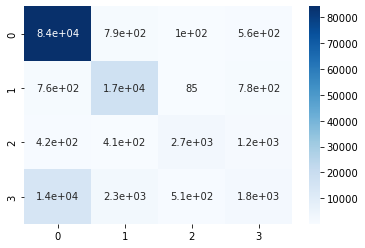

In [67]:
sns.heatmap(confusion_matrix(y_test, preds),annot=True, cmap='Blues')

Training neural network

In [31]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential

In [140]:
X_train.shape

(512900, 28)

In [144]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [157]:
model = Sequential()
model.add(Input(shape=(28, )))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               3712      
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                     

In [158]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [152]:
X_train = np.asarray(X_train).astype(np.float32)

In [159]:
model.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=64)

Epoch 1/5
5610/5610 [==============================] - 54s 9ms/step - loss: 0.8750 - accuracy: 0.6677 - val_loss: 0.9360 - val_accuracy: 0.6344
Epoch 2/5
5610/5610 [==============================] - 52s 9ms/step - loss: 0.8826 - accuracy: 0.6701 - val_loss: 0.9611 - val_accuracy: 0.6659
Epoch 3/5
5610/5610 [==============================] - 52s 9ms/step - loss: 0.9555 - accuracy: 0.6683 - val_loss: 2.1823 - val_accuracy: 0.4839
Epoch 4/5
5610/5610 [==============================] - 52s 9ms/step - loss: 0.8732 - accuracy: 0.6704 - val_loss: 0.9797 - val_accuracy: 0.6357
Epoch 5/5
5610/5610 [==============================] - 52s 9ms/step - loss: 0.8617 - accuracy: 0.6725 - val_loss: 1.0732 - val_accuracy: 0.6659


### Word Embeddings with Keras Sequential Models

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['url'], y, test_size=0.2, random_state=42)

In [32]:
X_train.shape

(512900,)

In [33]:
from tensorflow.keras.utils import pad_sequences
from keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

In [34]:
import re

In [35]:
split_by_special_character = r'[`!@#$%^&*()_+\-=\[\]{};\':"\\|,.<>\/?~]'

In [36]:
all_words = []
corpus = []
for url in tqdm(X_train):
    temp = re.split(split_by_special_character, url.lower())
    all_words += temp
    corpus.append(temp)

100%|██████████████████████████████████████████████████████████████████████| 512900/512900 [00:02<00:00, 181617.04it/s]


In [37]:
unique_words = set(all_words)
print(len(unique_words))

464213


In [38]:
VOCAB_LENGTH = len(unique_words) + 10 #Buffer of 10
VOCAB_LENGTH

464223

In [39]:
one_hot(url, VOCAB_LENGTH)

[192470, 115658, 196001, 370663, 158851, 100844, 66852, 168968]

In [40]:
embedded_sentences = [one_hot(url, VOCAB_LENGTH) for url in X_train]

In [41]:
length_long_sentence = 0
longest_url = ''
for url in X_train:
    temp = re.split(split_by_special_character, url.lower())
    if(length_long_sentence < len(temp)):
        length_long_sentence = len(temp)
        longest_url = url

In [42]:
length_long_sentence

373

In [43]:
length_long_sentence = len(re.split(split_by_special_character, longest_url.lower()))

In [44]:
length_long_sentence

373

In [45]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

In [46]:
padded_sentences.shape

(512900, 373)

In [47]:
padded_sentences

array([[198084, 178729, 178153, ...,      0,      0,      0],
       [ 87115, 391427, 178729, ...,      0,      0,      0],
       [ 87115, 369529,  51260, ...,      0,      0,      0],
       ...,
       [225933, 126522,  31826, ...,      0,      0,      0],
       [ 87115,  21347, 178729, ...,      0,      0,      0],
       [192470, 115658, 196001, ...,      0,      0,      0]])

#### Building a model

In [48]:
import tensorflow as tf

In [49]:
from tensorflow.keras.utils import to_categorical, plot_model

In [50]:
from tensorflow.keras import layers

In [51]:
df['target'].nunique()

4

In [52]:
padded_sentences.shape

(512900, 373)

In [53]:
Y_train = to_categorical(y_train)

In [54]:
X2_train, X2_test, y2_train, y2_test = train_test_split(padded_sentences, Y_train, random_state=42, test_size=0.3)

In [55]:
X2_train.shape

(359030, 373)

In [56]:
X3_train, X4_train, y3_train, y4_train = train_test_split(X2_train, y2_train, random_state=42, test_size=0.5)

In [57]:
X3_train.shape, X4_train.shape

((179515, 373), (179515, 373))

In [58]:
Y1_train = to_categorical(y1_train)

In [59]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X1_train, Y1_train, random_state=42, test_size=0.3)

In [60]:
X5_train.shape

(359030, 28)

In [61]:
X6_train, X7_train, y6_train, y7_train = train_test_split(X5_train, y5_train, random_state=42, test_size=0.5)

In [62]:
X6_train.shape, X7_train.shape

((179515, 28), (179515, 28))

### Word Embedding Model

In [9]:
model = Sequential()
model.add(Embedding(VOCAB_LENGTH, 10, input_length=length_long_sentence))
model.add(layers.Dropout(0.4))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 373, 10)           4642230   
                                                                 
 dropout (Dropout)           (None, 373, 10)           0         
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                      

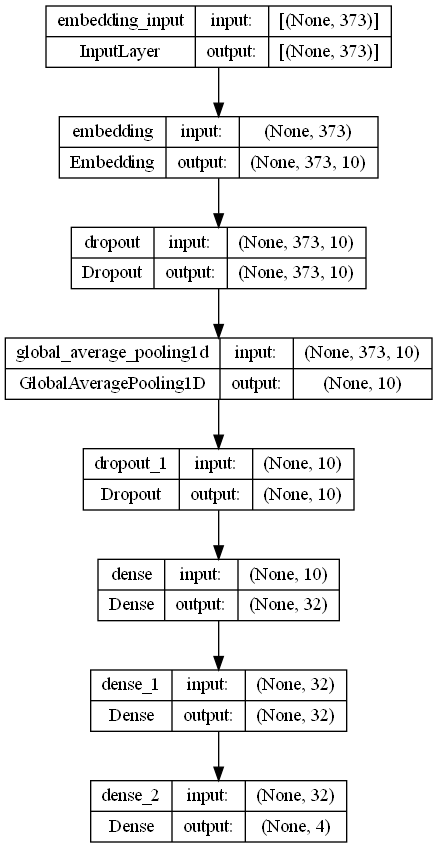

In [11]:
plot_model(model, to_file="../Models/url_embedding_arch.png", show_shapes=True)

In [116]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [119]:
model.fit(X2_train, y2_train, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
4488/4488 [==============================] - 39s 8ms/step - loss: 0.5653 - accuracy: 0.7915 - val_loss: 0.3374 - val_accuracy: 0.8673
Epoch 2/5
4488/4488 [==============================] - 37s 8ms/step - loss: 0.3472 - accuracy: 0.8662 - val_loss: 0.3226 - val_accuracy: 0.8740
Epoch 3/5
4488/4488 [==============================] - 37s 8ms/step - loss: 0.3072 - accuracy: 0.8785 - val_loss: 0.2632 - val_accuracy: 0.9101
Epoch 4/5
4488/4488 [==============================] - 37s 8ms/step - loss: 0.2736 - accuracy: 0.8940 - val_loss: 0.2408 - val_accuracy: 0.9181
Epoch 5/5
4488/4488 [==============================] - 38s 8ms/step - loss: 0.2372 - accuracy: 0.9112 - val_loss: 0.2002 - val_accuracy: 0.9291


In [120]:
model.fit(X3_train, y3_train, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
4488/4488 [==============================] - 38s 8ms/step - loss: 0.2558 - accuracy: 0.9036 - val_loss: 0.1821 - val_accuracy: 0.9321
Epoch 2/5
4488/4488 [==============================] - 38s 8ms/step - loss: 0.2297 - accuracy: 0.9125 - val_loss: 0.1705 - val_accuracy: 0.9387
Epoch 3/5
4488/4488 [==============================] - 37s 8ms/step - loss: 0.2112 - accuracy: 0.9204 - val_loss: 0.1669 - val_accuracy: 0.9410
Epoch 4/5
4488/4488 [==============================] - 37s 8ms/step - loss: 0.1930 - accuracy: 0.9279 - val_loss: 0.1630 - val_accuracy: 0.9421
Epoch 5/5
4488/4488 [==============================] - 38s 9ms/step - loss: 0.1804 - accuracy: 0.9325 - val_loss: 0.1624 - val_accuracy: 0.9405


In [121]:
model.evaluate(X1_test, y1_test)

4809/4809 [==============================] - 13s 3ms/step - loss: 0.1691 - accuracy: 0.9370


[0.1691291481256485, 0.9369857907295227]

In [122]:
model.save('../Models/url_clsf_word_embed')

INFO:tensorflow:Assets written to: ../Models/url_clsf_word_embed\assets


### Combining feature extraction and word embedfings

In [63]:
input_layer1 = layers.Input(shape=(373, ))
embedding = Embedding(VOCAB_LENGTH, 10, input_length=length_long_sentence)(input_layer1)
inner_layer1 = layers.Dropout(0.2)(embedding)
inner_layer1 = layers.GlobalAveragePooling1D()(inner_layer1)
inner_layer1 = layers.Dropout(0.2)(inner_layer1)
inner_layer1 = layers.Dense(32, activation='relu')(inner_layer1)

input_layer2 = layers.Input(shape=(28, ))
inner_layer2 = layers.Dense(64, activation='relu')(input_layer2)
inner_layer2 = layers.Dense(32, activation='relu')(inner_layer2)
inner_layer2 = layers.BatchNormalization()(inner_layer2)
inner_layer2 = layers.Dropout(0.4)(inner_layer2)

inner_layer2 = layers.Dense(64, activation='relu')(inner_layer2)
inner_layer2 = layers.Dense(64, activation='relu')(inner_layer2)
inner_layer2 = layers.BatchNormalization()(inner_layer2)
inner_layer2 = layers.Dropout(0.4)(inner_layer2)

concat = layers.concatenate([inner_layer1, inner_layer2])

outer_layers = layers.Dense(64, activation='relu')(concat)
outer_layers = layers.Dense(32, activation='relu')(outer_layers)
output_layer = layers.Dense(4, activation='softmax')(outer_layers)

model = tf.keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer, name="url_classification")
model.summary()

Model: "url_classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 64)           1856        ['input_2[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 373)]        0           []                               
                                                                                 

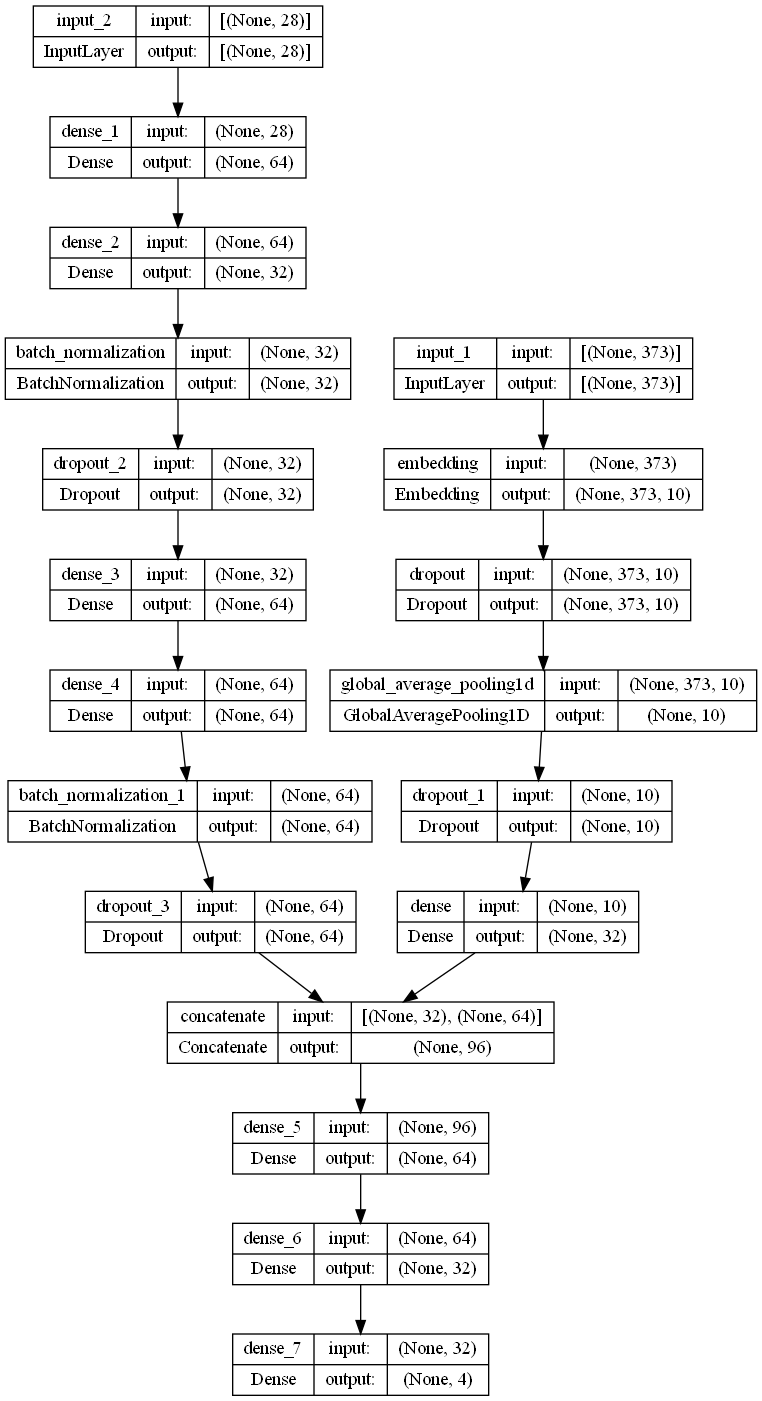

In [64]:
plot_model(model, to_file="url_classification_combined.png", show_shapes=True)

In [65]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
x3_train = np.asarray(X3_train).astype(np.float32)
x6_train = np.asarray(X6_train).astype(np.float32)

In [67]:
model.fit([x3_train, x6_train], y3_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
4488/4488 [==============================] - 47s 10ms/step - loss: 0.5437 - accuracy: 0.7985 - val_loss: 0.3409 - val_accuracy: 0.8684
Epoch 2/10
4488/4488 [==============================] - 42s 9ms/step - loss: 0.2984 - accuracy: 0.8894 - val_loss: 0.2779 - val_accuracy: 0.8971
Epoch 3/10
4488/4488 [==============================] - 43s 10ms/step - loss: 0.2515 - accuracy: 0.9061 - val_loss: 0.2948 - val_accuracy: 0.8961
Epoch 4/10
4488/4488 [==============================] - 45s 10ms/step - loss: 0.2234 - accuracy: 0.9160 - val_loss: 0.2204 - val_accuracy: 0.9194
Epoch 5/10
4488/4488 [==============================] - 45s 10ms/step - loss: 0.2036 - accuracy: 0.9232 - val_loss: 0.2787 - val_accuracy: 0.9036
Epoch 6/10
4488/4488 [==============================] - 43s 9ms/step - loss: 0.1847 - accuracy: 0.9304 - val_loss: 0.2271 - val_accuracy: 0.9143
Epoch 7/10
4488/4488 [==============================] - 43s 10ms/step - loss: 0.1581 - accuracy: 0.9425 - val_loss: 0.1957 - v

In [68]:
x4_train = np.asarray(X4_train).astype(np.float32)
x7_train = np.asarray(X7_train).astype(np.float32)

In [69]:
model.fit([x4_train, x7_train], y4_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
4488/4488 [==============================] - 39s 9ms/step - loss: 0.2093 - accuracy: 0.9208 - val_loss: 0.1878 - val_accuracy: 0.9206
Epoch 2/10
4488/4488 [==============================] - 40s 9ms/step - loss: 0.1856 - accuracy: 0.9300 - val_loss: 0.1590 - val_accuracy: 0.9439
Epoch 3/10
4488/4488 [==============================] - 40s 9ms/step - loss: 0.1697 - accuracy: 0.9366 - val_loss: 0.1530 - val_accuracy: 0.9442
Epoch 4/10
4488/4488 [==============================] - 48s 11ms/step - loss: 0.1568 - accuracy: 0.9413 - val_loss: 0.1587 - val_accuracy: 0.9441
Epoch 5/10
4488/4488 [==============================] - 46s 10ms/step - loss: 0.1443 - accuracy: 0.9466 - val_loss: 0.1635 - val_accuracy: 0.9403
Epoch 6/10
4488/4488 [==============================] - 47s 10ms/step - loss: 0.1338 - accuracy: 0.9509 - val_loss: 0.1556 - val_accuracy: 0.9440
Epoch 7/10
4488/4488 [==============================] - 48s 11ms/step - loss: 0.1248 - accuracy: 0.9551 - val_loss: 0.1603 - va

In [70]:
model.save('../Models/url_clsf_combined')

INFO:tensorflow:Assets written to: ../Models/url_clsf_combined\assets


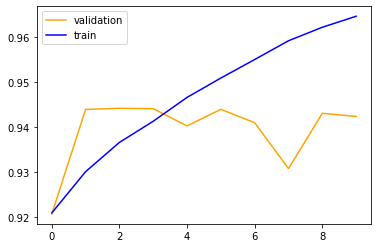

In [74]:
plt.plot(model.history.history['val_accuracy'], color='orange', label='validation')
plt.plot(model.history.history['accuracy'], color='blue', label='train')
plt.legend();

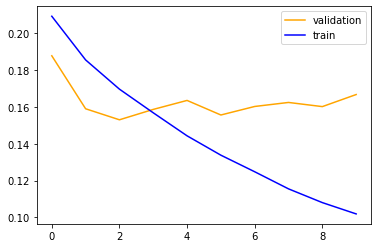

In [75]:
plt.plot(model.history.history['val_loss'], color='orange', label='validation')
plt.plot(model.history.history['loss'], color='blue', label='train')
plt.legend();

In [79]:
x2_test = np.asarray(X2_test).astype(np.float32)
x5_test = np.asarray(X5_test).astype(np.float32)

In [80]:
model.evaluate([x2_test, x5_test], y2_test)

4809/4809 [==============================] - 12s 3ms/step - loss: 0.1741 - accuracy: 0.9389


[0.1740693747997284, 0.9389224648475647]

In [81]:
print("Test Model Accuracy: 93.89%")

Test Model Accuracy: 93.89%


In [82]:
predications = model.predict([x2_test, x5_test])

4809/4809 [==============================] - 8s 2ms/step


In [99]:
y_pred = tf.argmax(input=predications, axis=1)

In [102]:
y_true = tf.argmax(input=y2_test, axis=1)

In [104]:
print("Accuracy score: ", accuracy_score(y_true, y_pred))

Accuracy score:  0.9389224670176123


In [106]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    102580
           1       0.97      0.99      0.98     22919
           2       0.98      0.92      0.95      5748
           3       0.88      0.69      0.78     22623

    accuracy                           0.94    153870
   macro avg       0.94      0.90      0.92    153870
weighted avg       0.94      0.94      0.94    153870



<AxesSubplot:>

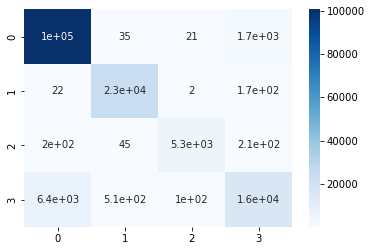

In [107]:
sns.heatmap(confusion_matrix(y_true, y_pred),annot=True, cmap='Blues')

### References:
https://medium.com/nerd-for-tech/url-feature-engineering-and-classification-66c0512fb34d  
https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/